<a href="https://colab.research.google.com/github/cesarhsfranca/Adam-HD/blob/main/Adam_com_Hiperpar%C3%A2metros_Desacoplados_e_Din%C3%A2micos_(Adam_HD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

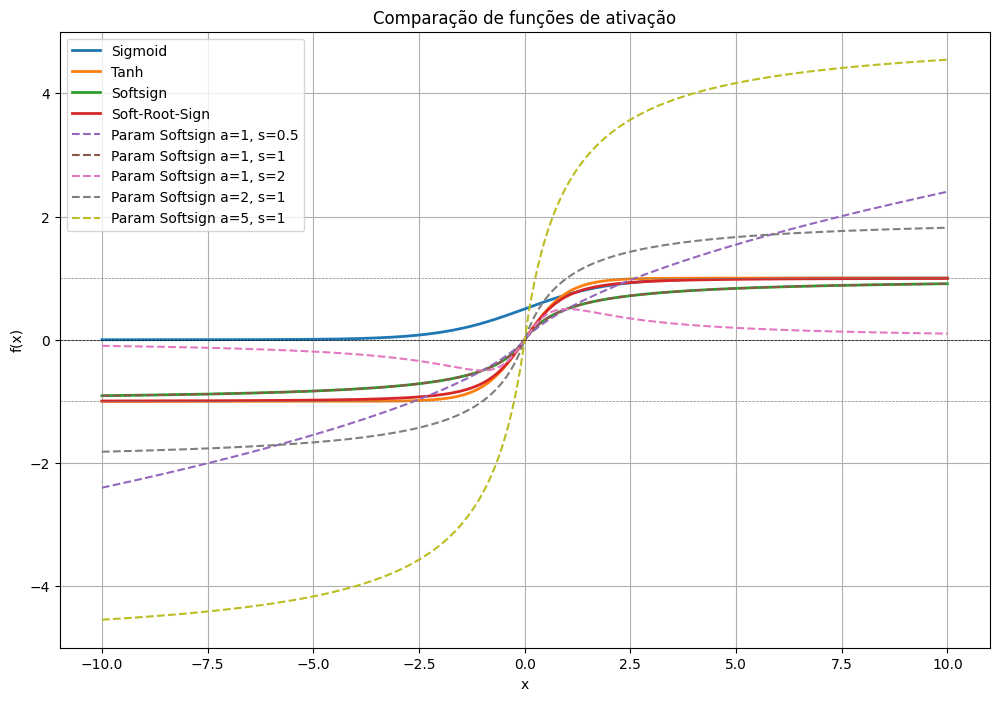

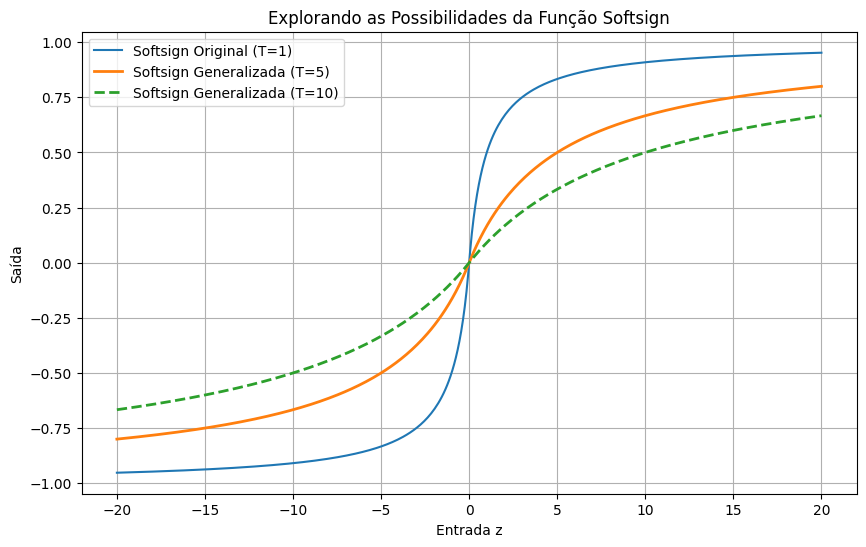


Executando o Algoritmo Adam com Hiperparâmetros Hierárquicos e Dinâmicos (Adam-HD)...


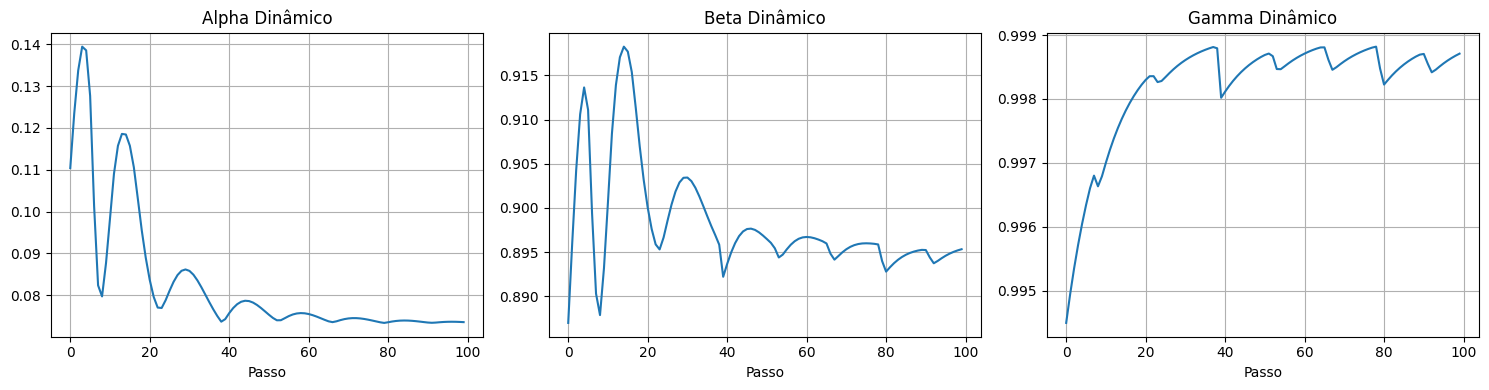

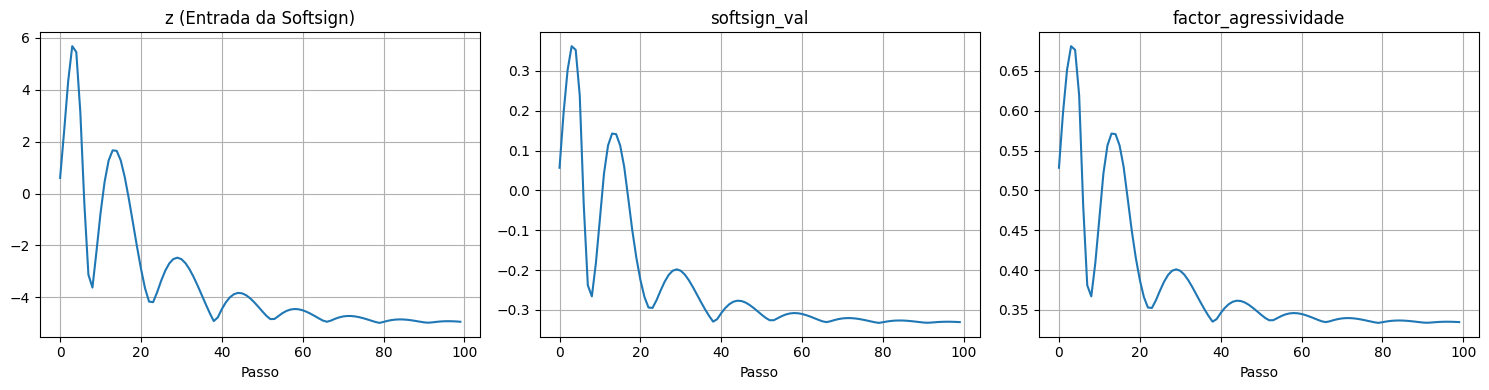


Plotando a trajetória na paisagem de perda fixa:


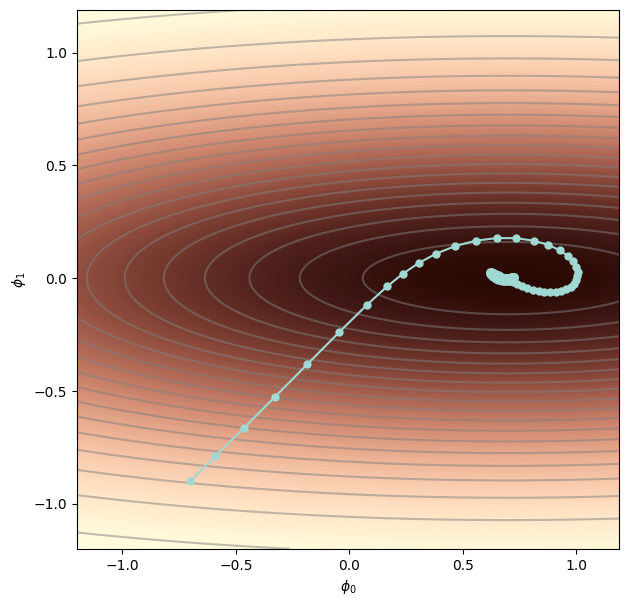


Treinando MLP profunda com MNIST usando Adam-HD...
Epoch 1: Loss = 0.2244
Epoch 2: Loss = 0.1239
Epoch 3: Loss = 0.1050
Epoch 4: Loss = 0.0927
Epoch 5: Loss = 0.0862
Epoch 6: Loss = 0.0769
Epoch 7: Loss = 0.0703
Epoch 8: Loss = 0.0702
Epoch 9: Loss = 0.0615
Epoch 10: Loss = 0.0681
Epoch 11: Loss = 0.0570
Epoch 12: Loss = 0.0620
Epoch 13: Loss = 0.0553
Epoch 14: Loss = 0.0566
Epoch 15: Loss = 0.0490
Epoch 16: Loss = 0.0564
Epoch 17: Loss = 0.0512
Epoch 18: Loss = 0.0525
Epoch 19: Loss = 0.0510
Epoch 20: Loss = 0.0550
Epoch 21: Loss = 0.0515
Epoch 22: Loss = 0.0463
Epoch 23: Loss = 0.0484
Epoch 24: Loss = 0.0529
Epoch 25: Loss = 0.0400
Epoch 26: Loss = 0.0438
Epoch 27: Loss = 0.0375
Epoch 28: Loss = 0.0458
Epoch 29: Loss = 0.0385
Epoch 30: Loss = 0.0589
Epoch 31: Loss = 0.0465
Epoch 32: Loss = 0.0356
Epoch 33: Loss = 0.0379
Epoch 34: Loss = 0.0481
Epoch 35: Loss = 0.0370
Epoch 36: Loss = 0.0303
Epoch 37: Loss = 0.0372
Epoch 38: Loss = 0.0232
Epoch 39: Loss = 0.0355
Epoch 40: Loss = 0.02

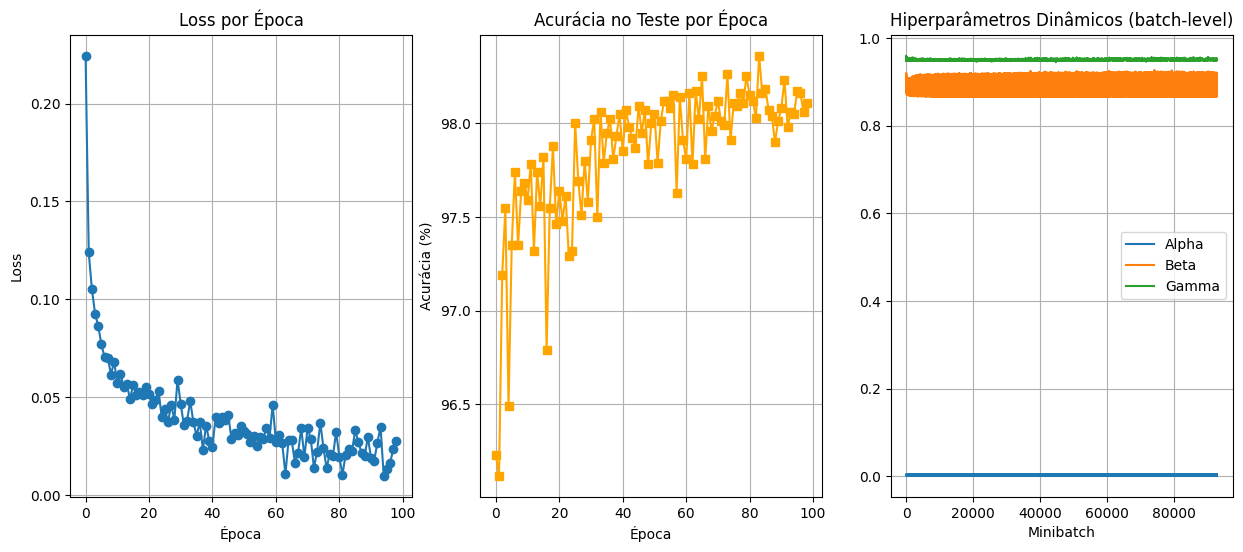

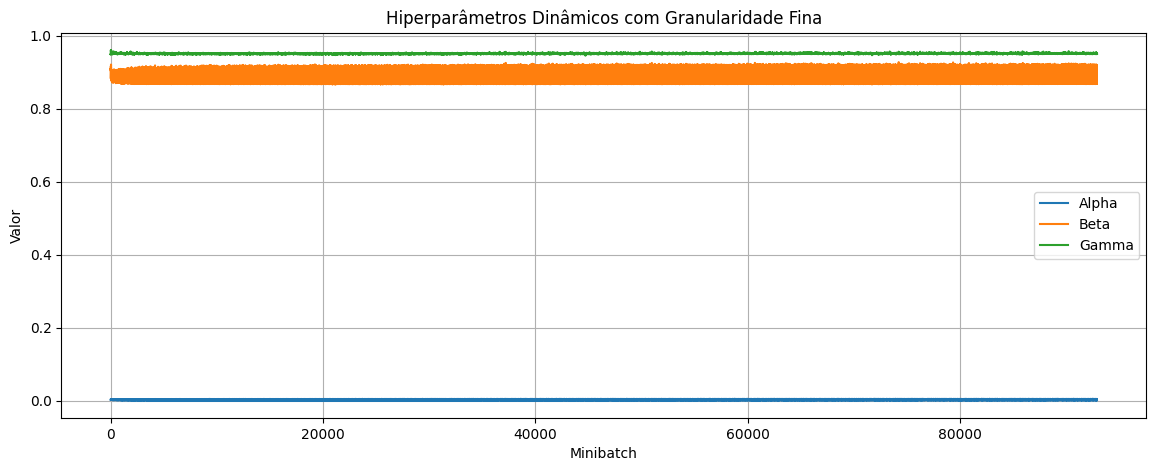

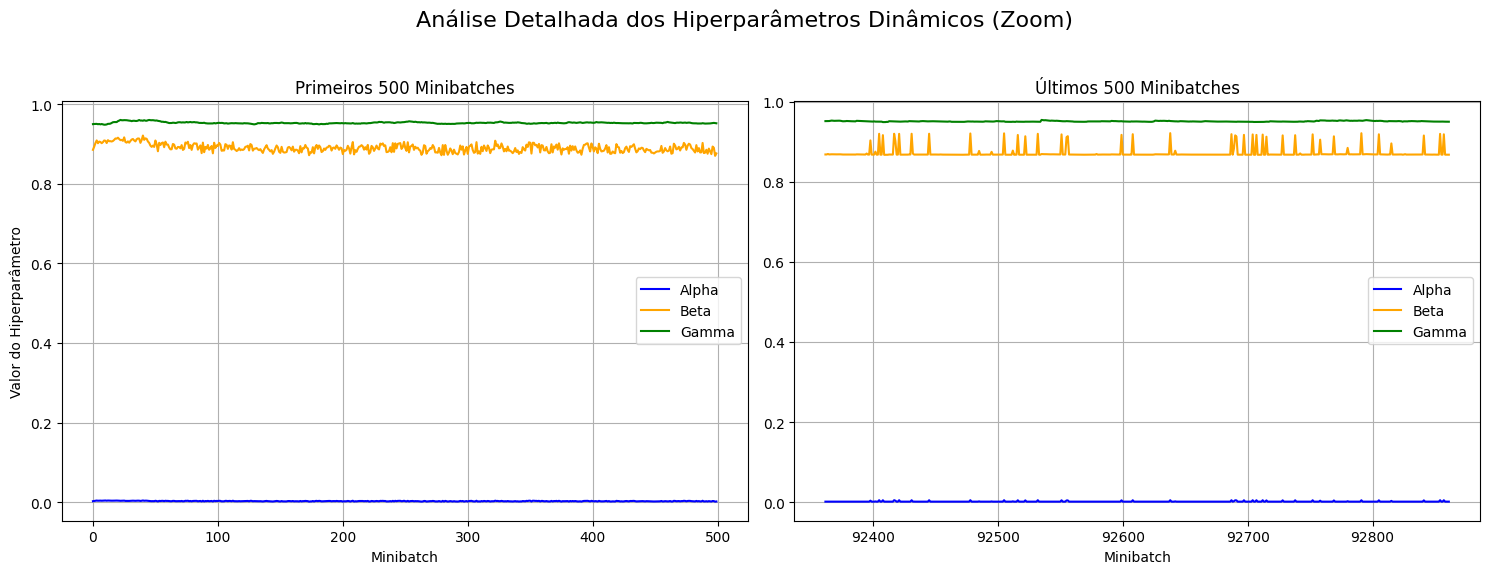


--- Gerando Gráfico Loss vs. Alpha Médio por Época ---


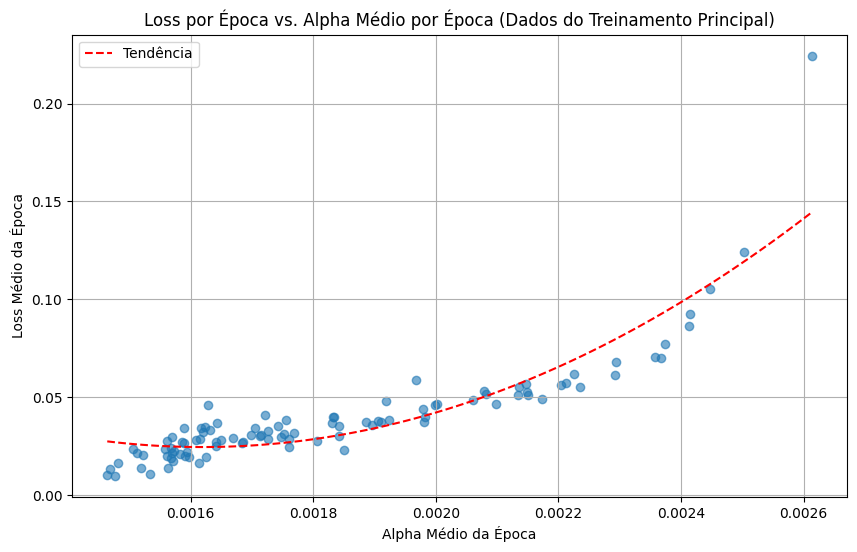


--- Gerando Gráfico da Razão de Robbins-Monro ---


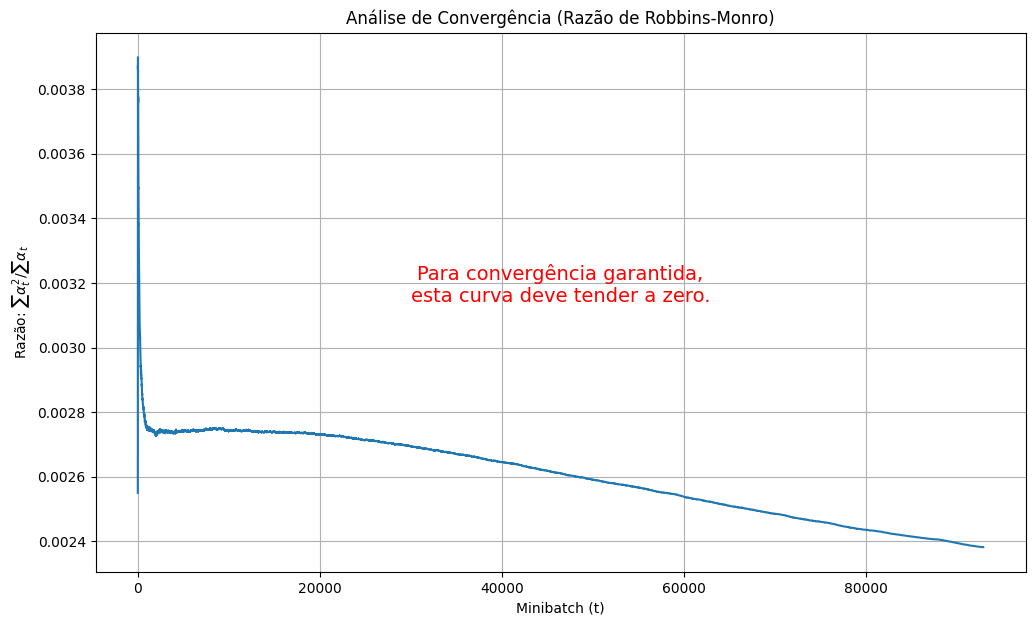


--- Gerando Gráfico Loss vs. Learning Rate (alpha) por Minibatch ---


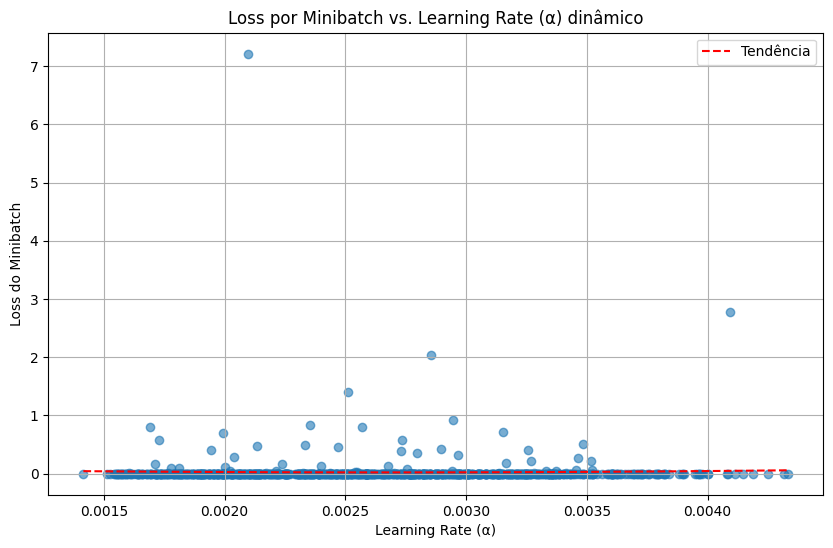


--- Gerando Gráfico da Norma do Gradiente por Minibatch ---


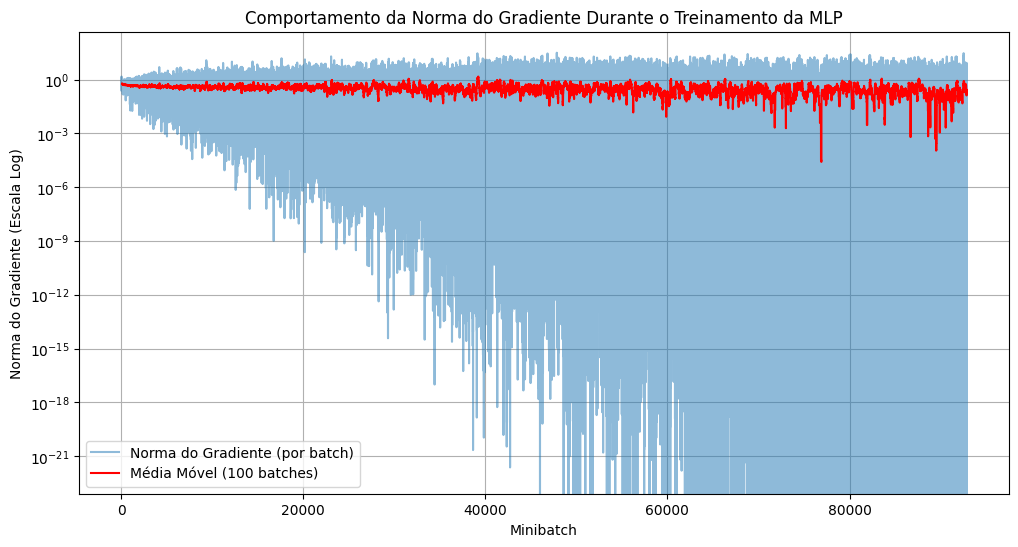

In [15]:

###############################################################################################################################
######### VISUALIZAÇÃO DA FUNÇÃO SOFTSIGN USADA PARA SUAVIZAR O LEARNING RATE ALFA EM FUNÇÃO DA VARIAÇÃO DO GRADIENTE #########
###############################################################################################################################

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def softsign(x):
    return x / (1 + np.abs(x))

def soft_root_sign(x):
    return x / np.sqrt(1 + x**2)

def param_softsign(x, a=1, s=1):
    return a * x / (np.abs(x)**s + 1)

x = np.linspace(-10, 10, 500)

plt.figure(figsize=(12, 8))

# Funções principais
plt.plot(x, sigmoid(x), label='Sigmoid', linewidth=2)
plt.plot(x, tanh(x), label='Tanh', linewidth=2)
plt.plot(x, softsign(x), label='Softsign', linewidth=2)
plt.plot(x, soft_root_sign(x), label='Soft-Root-Sign', linewidth=2)

# Parametric softsigns
for (a, s) in [(1, 0.5), (1, 1), (1, 2), (2, 1), (5, 1)]:
    plt.plot(x, param_softsign(x, a, s), '--', label=f'Param Softsign a={a}, s={s}')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axhline(1, color='gray', linewidth=0.5, linestyle='--')
plt.axhline(-1, color='gray', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.legend()
plt.title('Comparação de funções de ativação')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

# Visualizando o Efeito do Fator de Achatamento T

z = np.linspace(-20, 20, 400)
original_softsign = z / (1 + np.abs(z))
generalized_softsign_T5 = z / (5 + np.abs(z))
generalized_softsign_T10 = z / (10 + np.abs(z))

plt.figure(figsize=(10, 6))
plt.plot(z, original_softsign, label='Softsign Original (T=1)')
plt.plot(z, generalized_softsign_T5, label='Softsign Generalizada (T=5)', linewidth=2)
plt.plot(z, generalized_softsign_T10, label='Softsign Generalizada (T=10)', linewidth=2, linestyle='--')
plt.title('Explorando as Possibilidades da Função Softsign')
plt.xlabel('Entrada z')
plt.ylabel('Saída')
plt.grid(True)
plt.legend()
plt.show()


#######################################################################################################
#######################################################################################################
#
# -*- coding: utf-8 -*-
"""
Solução para o Notebook 6.5 com a implementação do
Adam com Hiperparâmetros Hierárquicos e Dinâmicos (Adam-HD)
e com restrição de limites para a trajetória (Clipping).
"""

# Código original do Notebook 6.5

# 1. IMPORTAÇÃO DAS BIBLIOTECAS E FUNÇÕES AUXILIARES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from collections import deque

# Novo para MLP e MNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


#######################################################################################################
#######################################################################################################

K_AGRESSIVIDADE_GLOBAL = 10.0
# Define o Fator de Achatamento T que será usado em ambas as implementações
FLATTENING_FACTOR_T_GLOBAL = 10.0
NUMERO_DE_PASSOS = 100 ######## NÚMERO DE ÉPOCAS ########
# Reproducibility
torch.manual_seed(0)
#######################################################################################################
#######################################################################################################

# Define a função de perda 2D que queremos minimizar.
def loss(phi0, phi1):
    height = np.exp(-0.5 * (phi1 * phi1) * 4.0)
    height = height * np.exp(-0.5 * (phi0 - 0.7) * (phi0 - 0.7) / 4.0)
    return 1.0 - height

# Calcula o gradiente da função de perda numericamente.
def get_loss_gradient(phi0, phi1):
    delta_phi = 0.00001
    gradient = np.zeros((2, 1))
    gradient[0] = (loss(phi0 + delta_phi / 2.0, phi1) - loss(phi0 - delta_phi / 2.0, phi1)) / delta_phi
    gradient[1] = (loss(phi0, phi1 + delta_phi / 2.0) - loss(phi0, phi1 - delta_phi / 2.0)) / delta_phi
    return gradient[:, 0]

# Calcula a paisagem de perda para uma área fixa.
def get_loss_function_for_plot(phi0_range=(-1.0, 1.0), phi1_range=(-1.0, 1.0)):
    phi0_values = np.arange(phi0_range[0], phi0_range[1], 0.01)
    phi1_values = np.arange(phi1_range[0], phi1_range[1], 0.01)

    phi0mesh, phi1mesh = np.meshgrid(phi0_values, phi1_values)
    loss_function = np.zeros((phi1_values.size, phi0_values.size))

    for idphi1, phi1 in enumerate(phi1_values):
        for idphi0, phi0 in enumerate(phi0_values):
            loss_function[idphi1, idphi0] = loss(phi0, phi1)

    return loss_function, phi0mesh, phi1mesh

# Código para o mapa de cores
my_colormap_vals_hex = (
    '2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09',
    '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f',
    '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814',
    '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18',
    '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d',
    '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821',
    '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26',
    '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a',
    '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f',
    '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134',
    '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a',
    '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f',
    '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545',
    '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b',
    'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451',
    'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57',
    'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d',
    'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64',
    'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b',
    'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72',
    'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a',
    'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81',
    'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589',
    'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91',
    'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a',
    'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3',
    'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac',
    'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6',
    'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf',
    'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca',
    'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5',
    'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0'
)
my_colormap_vals_dec = np.array([int(element, base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec / (256 * 256))
g = np.floor((my_colormap_vals_dec - r * 256 * 256) / 256)
b = np.floor(my_colormap_vals_dec - r * 256 * 256 - g * 256)
my_colormap_vals = np.vstack((r, g, b)).transpose() / 255.0
my_colormap = ListedColormap(my_colormap_vals)

def draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, opt_path):
    fig = plt.figure()
    ax = plt.axes()
    fig.set_size_inches(7, 7)
    ax.contourf(phi0mesh, phi1mesh, loss_function, 256, cmap=my_colormap)
    ax.contour(phi0mesh, phi1mesh, loss_function, 20, colors=['#80808080'])
    ax.plot(opt_path[0, :], opt_path[1, :], '-', color='#a0d9d3ff')
    ax.plot(opt_path[0, :], opt_path[1, :], '.', color='#a0d9d3ff', markersize=10)
    ax.set_xlabel(r"$\phi_0$")
    ax.set_ylabel(r"$\phi_1$")
    plt.show()

# --- 3. IMPLEMENTAÇÃO DO NOVO ALGORITMO: ADAM-HD (Hierárquico e Dinâmico) ---
# <<<< ALTERAÇÃO 1: Adicionado flattening_factor_T à função >>>>
def adam_hierarquico_dinamico(start_posn, n_steps,
                               # Limites para os hiperparâmetros
                               alpha_range=(0.01, 0.2), # (min, max)
                               beta_range=(0.85, 0.99), # (min, max)
                               gamma_range=(0.99, 0.999), # (min, max)
                               # Parâmetros de controle para os sinais
                               k_agressividade=K_AGRESSIVIDADE_GLOBAL, # Sensibilidade à norma do gradiente
                               flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL, # Fator de achatamento
                               smoothing_direcao=0.9, # Suavização para o cosseno
                               epsilon=1e-8):

    # --- Inicializações ---
    grad_path = np.zeros((2, n_steps + 1))
    grad_path[:, 0] = start_posn[:, 0]
    m = np.zeros_like(grad_path[:, 0])
    v = np.zeros_like(grad_path[:, 0])
    grad_anterior = np.zeros_like(grad_path[:,0])
    cosseno_suavizado = 0.0

    # Históricos para visualização
    alpha_hist, beta_hist, gamma_hist = [], [], []
    z_hist, softsign_hist, factor_agressividade_hist = [], [], [] # Novos históricos

    for c_step in range(n_steps):
        pos_atual = grad_path[:, c_step]
        grad_atual = get_loss_gradient(pos_atual[0], pos_atual[1])

        # --- CÁLCULO DOS SINAIS DE CONTROLE ---
        grad_norm = np.linalg.norm(grad_atual)
        z = k_agressividade * (grad_norm - 0.5)

        # <<<< ALTERAÇÃO 2: Uso da Softsign Generalizada >>>>
        softsign_val = z / (flattening_factor_T + np.abs(z))

        factor_agressividade = 0.5 * (softsign_val + 1)

        # Armazena os novos valores para plotagem
        z_hist.append(z)
        softsign_hist.append(softsign_val)
        factor_agressividade_hist.append(factor_agressividade)

        if np.linalg.norm(grad_anterior) > 0 and grad_norm > 0:
            cosseno_atual = np.dot(grad_atual, grad_anterior) / (grad_norm * np.linalg.norm(grad_anterior))
        else:
            cosseno_atual = 0.0
        cosseno_suavizado = smoothing_direcao * cosseno_suavizado + (1 - smoothing_direcao) * cosseno_atual
        factor_direcao = (cosseno_suavizado + 1) / 2.0

        alpha_min, alpha_max = alpha_range
        alpha_dyn = alpha_min + (alpha_max - alpha_min) * factor_agressividade

        beta_min, beta_max = beta_range
        beta_alvo = beta_min + (beta_max - beta_min) * factor_direcao
        beta_dyn = factor_agressividade * beta_alvo + (1 - factor_agressividade) * beta_min

        gamma_min, gamma_max = gamma_range
        gamma_dyn = gamma_min + (gamma_max - gamma_min) * factor_direcao

        alpha_hist.append(alpha_dyn); beta_hist.append(beta_dyn); gamma_hist.append(gamma_dyn)

        m = beta_dyn * m + (1 - beta_dyn) * grad_atual
        v = gamma_dyn * v + (1 - gamma_dyn) * np.square(grad_atual)

        m_tilde = m / (1 - np.power(beta_dyn, c_step + 1))
        v_tilde = v / (1 - np.power(gamma_dyn, c_step + 1))

        grad_path[:, c_step + 1] = pos_atual - alpha_dyn * m_tilde / (np.sqrt(v_tilde) + epsilon)

        grad_anterior = grad_atual

    # --- VISUALIZAÇÃO DOS RESULTADOS ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.plot(alpha_hist); plt.title('Alpha Dinâmico'); plt.grid(True); plt.xlabel('Passo')
    plt.subplot(1, 3, 2); plt.plot(beta_hist); plt.title('Beta Dinâmico'); plt.grid(True); plt.xlabel('Passo')
    plt.subplot(1, 3, 3); plt.plot(gamma_hist); plt.title('Gamma Dinâmico'); plt.grid(True); plt.xlabel('Passo')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.plot(z_hist); plt.title('z (Entrada da Softsign)'); plt.grid(True); plt.xlabel('Passo')
    plt.subplot(1, 3, 2); plt.plot(softsign_hist); plt.title('softsign_val'); plt.grid(True); plt.xlabel('Passo')
    plt.subplot(1, 3, 3); plt.plot(factor_agressividade_hist); plt.title('factor_agressividade'); plt.grid(True); plt.xlabel('Passo')
    plt.tight_layout(); plt.show()

    return grad_path

# --- 4. EXECUÇÃO DO NOVO ALGORITMO ---
print("\nExecutando o Algoritmo Adam com Hiperparâmetros Hierárquicos e Dinâmicos (Adam-HD)...")

loss_function, phi0mesh, phi1mesh = get_loss_function_for_plot(phi0_range=(-1.2, 1.2), phi1_range=(-1.2, 1.2))
start_posn = np.zeros((2, 1)); start_posn[0, 0] = -0.7; start_posn[1, 0] = -0.9
numero_de_passos = NUMERO_DE_PASSOS ############################# NÚMERO DE ÉPOCAS DEFINIDO ACIMA NO INÍCIO DO CÓDIGO ###################################
grad_path_hd = adam_hierarquico_dinamico(start_posn, n_steps=numero_de_passos)

print("\nPlotando a trajetória na paisagem de perda fixa:")
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path_hd)

# --- INÍCIO DA NOVA SEÇÃO: MLP PROFUNDA COM MNIST ---

class MLPDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# <<<< ALTERAÇÃO 3: Adicionado flattening_factor_T à classe >>>>
class AdamHDOptimizer(torch.optim.Optimizer):
    def __init__(self, params, alpha_range=(0.0001, 0.005), beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 k_agressividade=K_AGRESSIVIDADE_GLOBAL,
                 flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL, # Novo hiperparâmetro
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):

        defaults = dict(alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
                        k_agressividade=k_agressividade, flattening_factor_T=flattening_factor_T,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon,
                        beta_norm=beta_norm)
        super().__init__(params, defaults)
        self.alpha_hist = []
        self.beta_hist = []
        self.gamma_hist = []
        self.grad_norm_hist = [] # <--- LINHA NOVA 1: INICIA A LISTA

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            k = group['k_agressividade']
            T = group['flattening_factor_T']
            smoothing = group['smoothing_direcao']
            eps = group['epsilon']
            beta_norm = group['beta_norm']

            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                grad = p.grad.data

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)

                state['step'] += 1
                m, v = state['m'], state['v']
                grad_prev, cos_smooth = state['grad_prev'], state['cos_smooth']
                grad_norm = grad.norm()

                avg_grad_norm = state['avg_grad_norm']
                if avg_grad_norm == 0:
                    avg_grad_norm = grad_norm.clone()
                else:
                    avg_grad_norm = beta_norm * avg_grad_norm + (1 - beta_norm) * grad_norm
                state['avg_grad_norm'] = avg_grad_norm.clone()

                z = k * ( (grad_norm / (avg_grad_norm + eps)) - 1.0 )

                softsign = z / (T + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)

                if grad_prev.norm() > 0 and grad_norm > 0:
                    cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm())
                else:
                    cos_atual = torch.tensor(0.0, device=p.device)
                cos_smooth = smoothing * cos_smooth + (1 - smoothing) * cos_atual
                factor_direcao = (cos_smooth + 1) / 2.0

                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao

                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)

                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2

                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)

                state['grad_prev'] = grad.clone()
                state['cos_smooth'] = cos_smooth.clone()

                if id(p) == id(group['params'][0]):
                    self.alpha_hist.append(alpha.item())
                    self.beta_hist.append(beta.item())
                    self.gamma_hist.append(gamma.item())
                    self.grad_norm_hist.append(grad_norm.item()) # <--- LINHA NOVA 2: SALVA O VALOR

# --- Treinamento com Adam-HD ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=1000, shuffle=False)

model = MLPDeep().to(device)

# <<<< ALTERAÇÃO 5: Instanciando o otimizador com os novos parâmetros >>>>
# Agora você pode tunar K_AGRESSIVIDADE_GLOBAL e FLATTENING_FACTOR_T_GLOBAL no topo do script
optimizer = AdamHDOptimizer(model.parameters(),
                            k_agressividade=K_AGRESSIVIDADE_GLOBAL,
                            flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL,
                            alpha_range=(0.0001, 0.005)) # Usando uma faixa de alpha mais conservadora

criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []
weights_history = [] # <--- LISTA NOVA PARA SALVAR OS PESOS

print("\nTreinando MLP profunda com MNIST usando Adam-HD...")
for epoch in range(1, numero_de_passos): ############################### NUMBER OF EPOCHS################################
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- Salva os pesos ao final de cada época ---
    with torch.no_grad():
        epoch_weights = torch.cat([p.data.view(-1) for p in model.parameters()])
        weights_history.append(epoch_weights.cpu().numpy())
    # ---------------------------------------------

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)

print(f"\nAcurácia final com Adam-HD: {test_accuracies[-1]:.2f}%")

# --- GRÁFICOS DE DESEMPENHO ---
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses, marker='o')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_accuracies, marker='s', color='orange')
plt.title('Acurácia no Teste por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(optimizer.alpha_hist, label='Alpha')
plt.plot(optimizer.beta_hist, label='Beta')
plt.plot(optimizer.gamma_hist, label='Gamma')
plt.title('Hiperparâmetros Dinâmicos (batch-level)')
plt.xlabel('Minibatch')
plt.legend()
plt.grid(True)
plt.show() # Adicionado show para a primeira figura de gráficos

# --- GRÁFICO SEPARADO COM MAIS GRANULARIDADE ---
if optimizer.alpha_hist: # Checa se a lista não está vazia
    plt.figure(figsize=(14, 5))
    plt.plot(optimizer.alpha_hist, label='Alpha', linewidth=1.5)
    plt.plot(optimizer.beta_hist, label='Beta', linewidth=1.5)
    plt.plot(optimizer.gamma_hist, label='Gamma', linewidth=1.5)
    plt.title('Hiperparâmetros Dinâmicos com Granularidade Fina')
    plt.xlabel('Minibatch')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define o número de pontos do início e do fim que queremos visualizar
zoom_points = 500

if len(optimizer.alpha_hist) > zoom_points * 2:
    plt.figure(figsize=(15, 6))
    plt.suptitle('Análise Detalhada dos Hiperparâmetros Dinâmicos (Zoom)', fontsize=16)

    # --- Subplot 1: Zoom no INÍCIO do treinamento ---
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(optimizer.alpha_hist[:zoom_points], label='Alpha', color='blue')
    ax1.plot(optimizer.beta_hist[:zoom_points], label='Beta', color='orange')
    ax1.plot(optimizer.gamma_hist[:zoom_points], label='Gamma', color='green')
    ax1.set_title(f'Primeiros {zoom_points} Minibatches')
    ax1.set_xlabel('Minibatch')
    ax1.set_ylabel('Valor do Hiperparâmetro')
    ax1.legend()
    ax1.grid(True)

    # --- Subplot 2: Zoom no FIM do treinamento ---
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(range(len(optimizer.alpha_hist) - zoom_points, len(optimizer.alpha_hist)),
             optimizer.alpha_hist[-zoom_points:], label='Alpha', color='blue')
    ax2.plot(range(len(optimizer.beta_hist) - zoom_points, len(optimizer.beta_hist)),
             optimizer.beta_hist[-zoom_points:], label='Beta', color='orange')
    ax2.plot(range(len(optimizer.gamma_hist) - zoom_points, len(optimizer.gamma_hist)),
             optimizer.gamma_hist[-zoom_points:], label='Gamma', color='green')
    ax2.set_title(f'Últimos {zoom_points} Minibatches')
    ax2.set_xlabel('Minibatch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("\nNão foi possível gerar o gráfico com zoom: o número de minibatches é menor que o necessário para o zoom.")

# --- FIM DA SEÇÃO MLP ---
#######################################################################################################################
#######################################################################################################################
# --- NOVO GRÁFICO: Loss vs. Learning Rate do Treinamento Principal ---

# Checa se o treinamento foi executado
if train_losses and optimizer.alpha_hist:
    print("\n--- Gerando Gráfico Loss vs. Alpha Médio por Época ---")

    # Calcula o número de batches por época
    num_batches_per_epoch = len(train_loader)

    # Calcula o alpha médio para cada época
    avg_alpha_per_epoch = []
    for i in range(len(train_losses)):
        start_index = i * num_batches_per_epoch
        end_index = start_index + num_batches_per_epoch
        epoch_alphas = optimizer.alpha_hist[start_index:end_index]
        if epoch_alphas:
            avg_alpha_per_epoch.append(np.mean(epoch_alphas))
        else:
            # Caso o treinamento seja interrompido, evita erros
            break

    # Garante que temos o mesmo número de pontos para loss e alpha
    num_epochs_to_plot = len(avg_alpha_per_epoch)

    # Cria o gráfico de dispersão (scatter plot)
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_alpha_per_epoch, train_losses[:num_epochs_to_plot], alpha=0.6)

    # Adiciona uma linha de tendência (regressão polinomial simples) para ajudar na visualização
    if num_epochs_to_plot > 2:
        try:
            z = np.polyfit(avg_alpha_per_epoch, train_losses[:num_epochs_to_plot], 2)
            p = np.poly1d(z)
            xp = np.linspace(min(avg_alpha_per_epoch), max(avg_alpha_per_epoch), 100)
            plt.plot(xp, p(xp), "r--", label="Tendência")
        except:
             print("Não foi possível gerar a linha de tendência.")

    plt.title('Loss por Época vs. Alpha Médio por Época (Dados do Treinamento Principal)')
    plt.xlabel('Alpha Médio da Época')
    plt.ylabel('Loss Médio da Época')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- NOVO GRÁFICO (VERSÃO CORRETA): Análise da Razão de Robbins-Monro ---

print("\n--- Gerando Gráfico da Razão de Robbins-Monro ---")

# Checa se o treinamento foi executado
if optimizer.alpha_hist:
    # Calcula as somas cumulativas
    sum_alpha = np.cumsum(optimizer.alpha_hist)
    sum_alpha_sq = np.cumsum(np.array(optimizer.alpha_hist)**2)

    # Calcula a razão, evitando divisão por zero no início
    ratio = sum_alpha_sq / (sum_alpha + 1e-9)

    plt.figure(figsize=(12, 7))
    plt.plot(ratio)
    plt.title(r'Análise de Convergência (Razão de Robbins-Monro)')
    plt.xlabel('Minibatch (t)')
    plt.ylabel(r'Razão: $\sum \alpha_t^2 / \sum \alpha_t$')
    plt.grid(True)
    plt.text(0.5, 0.5, 'Para convergência garantida,\nesta curva deve tender a zero.',
             transform=plt.gca().transAxes, ha='center', fontsize=14, color='red')
    plt.show()

# --- NOVO GRÁFICO: Loss vs. Learning Rate por Minibatch ---

# Verifica se há históricos suficientes
if len(optimizer.alpha_hist) > 0 and len(train_losses) > 0:
    print("\n--- Gerando Gráfico Loss vs. Learning Rate (alpha) por Minibatch ---")

    # Concatena todas as losses por minibatch (flatten)
    all_minibatch_losses = []

    model.eval()  # Certifica-se de que não há dropout/batchnorm afetando
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            all_minibatch_losses.append(loss.item())

    # Garante que os tamanhos batem
    min_len = min(len(all_minibatch_losses), len(optimizer.alpha_hist))
    x = optimizer.alpha_hist[:min_len]
    y = all_minibatch_losses[:min_len]

    # Cria o gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.6)

    # Adiciona linha de tendência se houver pontos suficientes
    if len(x) > 2:
        try:
            z = np.polyfit(x, y, 2)  # Regressão polinomial de 2ª ordem
            p = np.poly1d(z)
            xp = np.linspace(min(x), max(x), 100)
            plt.plot(xp, p(xp), "r--", label="Tendência")
        except:
            print("Não foi possível ajustar a linha de tendência.")

    plt.title('Loss por Minibatch vs. Learning Rate (α) dinâmico')
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Loss do Minibatch')
    plt.grid(True)
    plt.legend()
    plt.show()

############################################################################################################################################################################
############################################################################################################################################################################
####################################################################
# --- NOVO GRÁFICO: NORMA DO GRADIENTE POR MINIBATCH ---
####################################################################

if hasattr(optimizer, 'grad_norm_hist') and optimizer.grad_norm_hist:
    print("\n--- Gerando Gráfico da Norma do Gradiente por Minibatch ---")

    plt.figure(figsize=(12, 6))

    # Plota a norma do gradiente original (batch a batch), que é bem ruidosa
    plt.plot(optimizer.grad_norm_hist, label='Norma do Gradiente (por batch)', alpha=0.5)

    # Adiciona uma média móvel para suavizar a curva e ver a tendência
    window_size = 100 # Tamanho da janela da média móvel
    if len(optimizer.grad_norm_hist) > window_size:
        # Usa np.convolve para calcular a média móvel de forma eficiente
        moving_avg = np.convolve(optimizer.grad_norm_hist, np.ones(window_size)/window_size, mode='valid')
        # Ajusta o eixo x para a média móvel
        plt.plot(np.arange(window_size - 1, len(optimizer.grad_norm_hist)), moving_avg, color='red', label=f'Média Móvel ({window_size} batches)')

    plt.title('Comportamento da Norma do Gradiente Durante o Treinamento da MLP')
    plt.xlabel('Minibatch')
    plt.ylabel('Norma do Gradiente (Escala Log)')
    plt.yscale('log') # Escala logarítmica é melhor para visualizar a queda de ordens de magnitude
    plt.legend()
    plt.grid(True)
    plt.show()


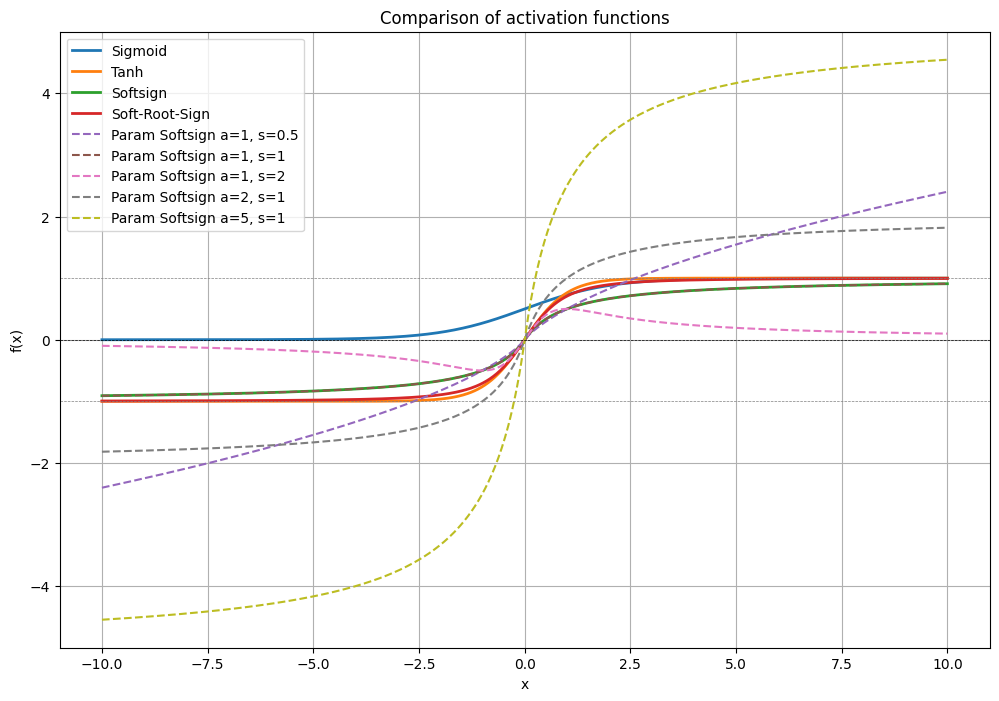

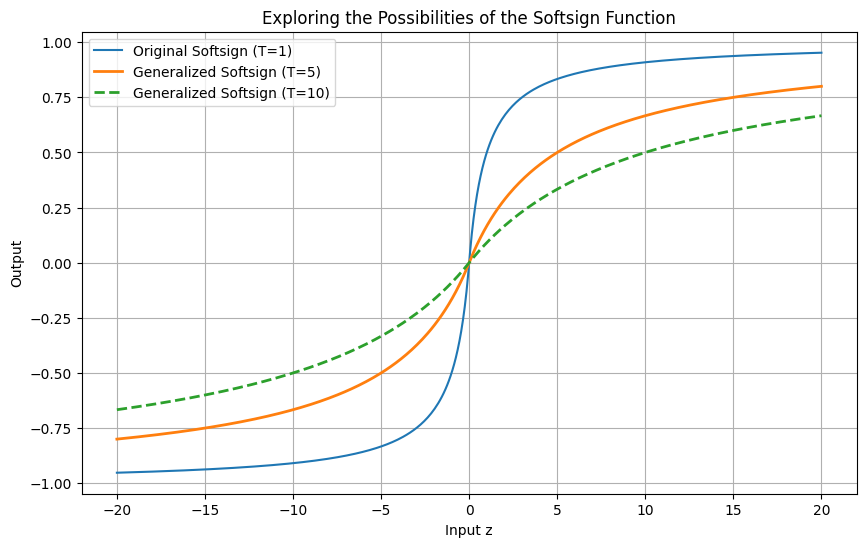


Running the Adam Algorithm with Hierarchical and Dynamic Hyperparameters (Adam-HD)...


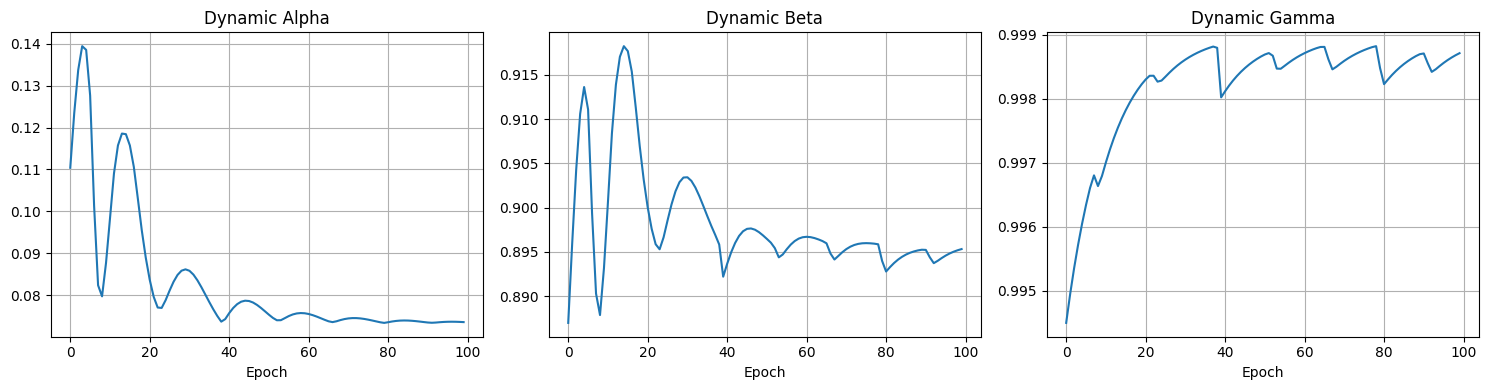

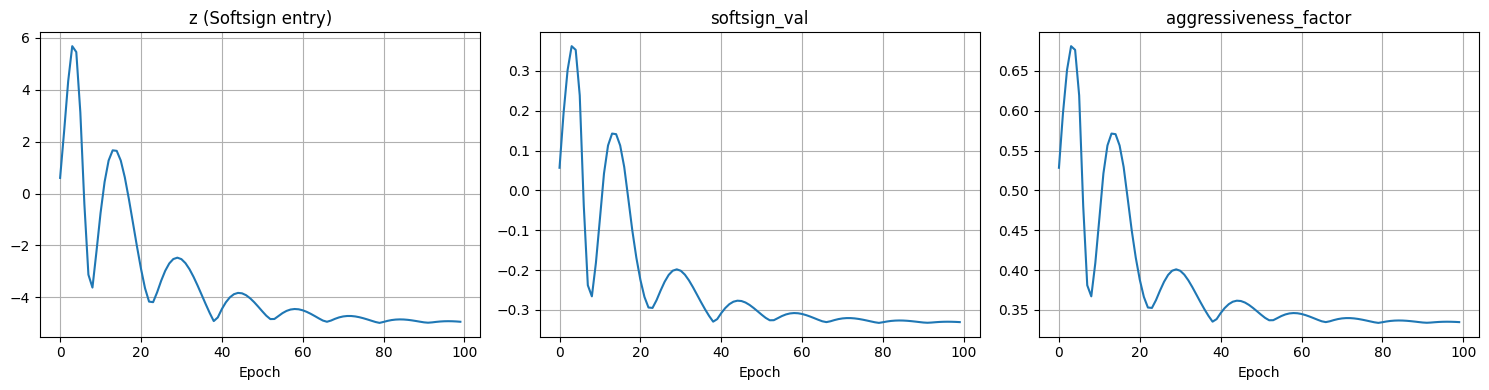


Plotting the trajectory in the fixed loss landscape:


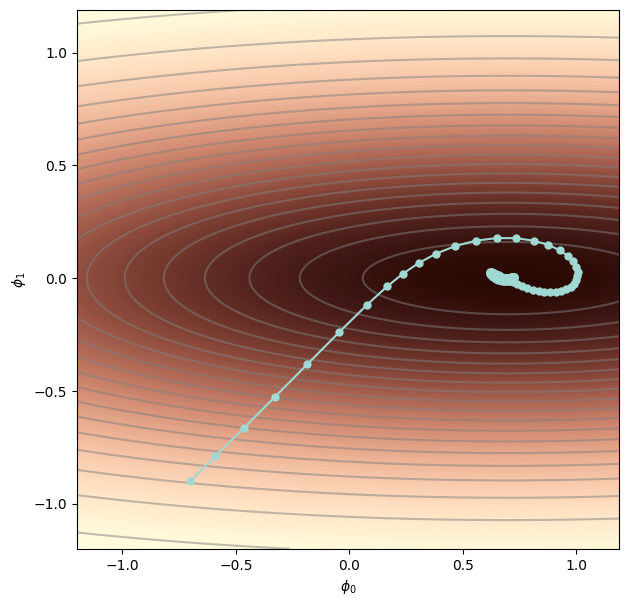


Training Deep MLP with MNIST using Adam-HD...
Epoch 1: Loss = 0.2246
Epoch 2: Loss = 0.1200
Epoch 3: Loss = 0.1005
Epoch 4: Loss = 0.0907
Epoch 5: Loss = 0.0834
Epoch 6: Loss = 0.0756
Epoch 7: Loss = 0.0682
Epoch 8: Loss = 0.0723
Epoch 9: Loss = 0.0673
Epoch 10: Loss = 0.0612
Epoch 11: Loss = 0.0571
Epoch 12: Loss = 0.0618
Epoch 13: Loss = 0.0541
Epoch 14: Loss = 0.0488
Epoch 15: Loss = 0.0467
Epoch 16: Loss = 0.0450
Epoch 17: Loss = 0.0437
Epoch 18: Loss = 0.0455
Epoch 19: Loss = 0.0467
Epoch 20: Loss = 0.0389
Epoch 21: Loss = 0.0408
Epoch 22: Loss = 0.0478
Epoch 23: Loss = 0.0408
Epoch 24: Loss = 0.0415
Epoch 25: Loss = 0.0441
Epoch 26: Loss = 0.0431
Epoch 27: Loss = 0.0525
Epoch 28: Loss = 0.0369
Epoch 29: Loss = 0.0389
Epoch 30: Loss = 0.0378
Epoch 31: Loss = 0.0349
Epoch 32: Loss = 0.0285
Epoch 33: Loss = 0.0359
Epoch 34: Loss = 0.0346
Epoch 35: Loss = 0.0324
Epoch 36: Loss = 0.0292
Epoch 37: Loss = 0.0315
Epoch 38: Loss = 0.0296
Epoch 39: Loss = 0.0301
Epoch 40: Loss = 0.0270
Ep

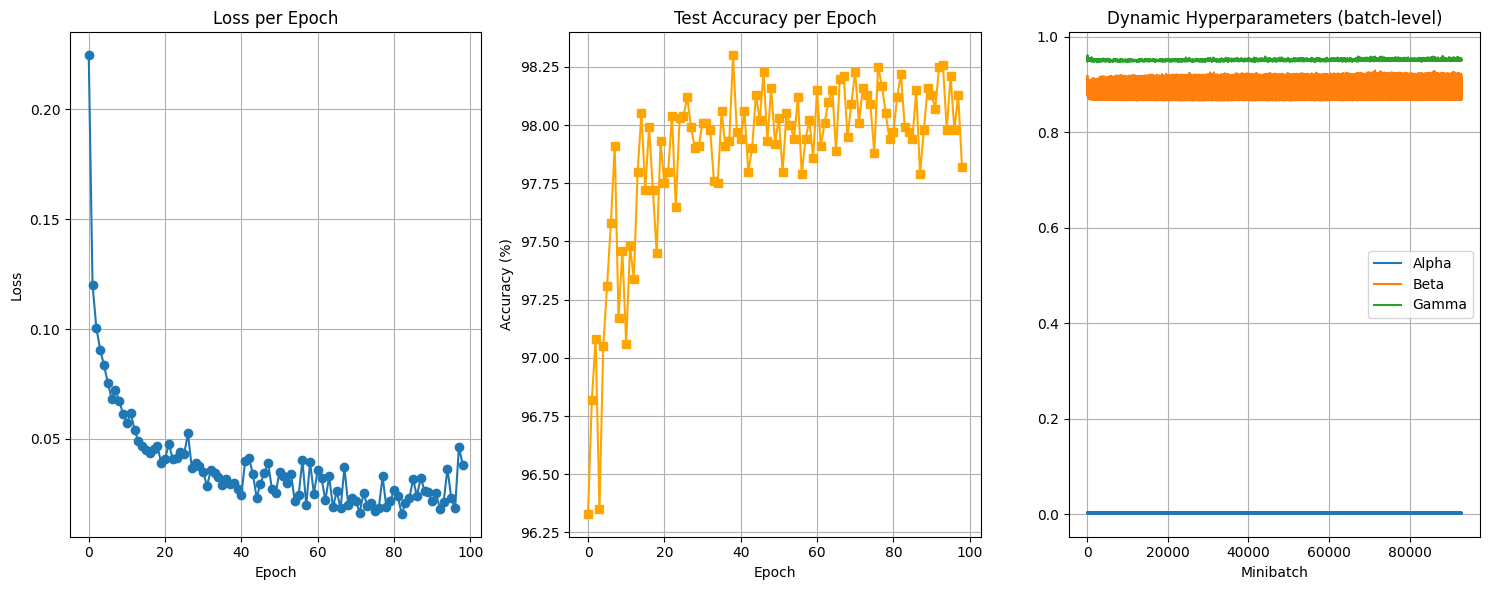

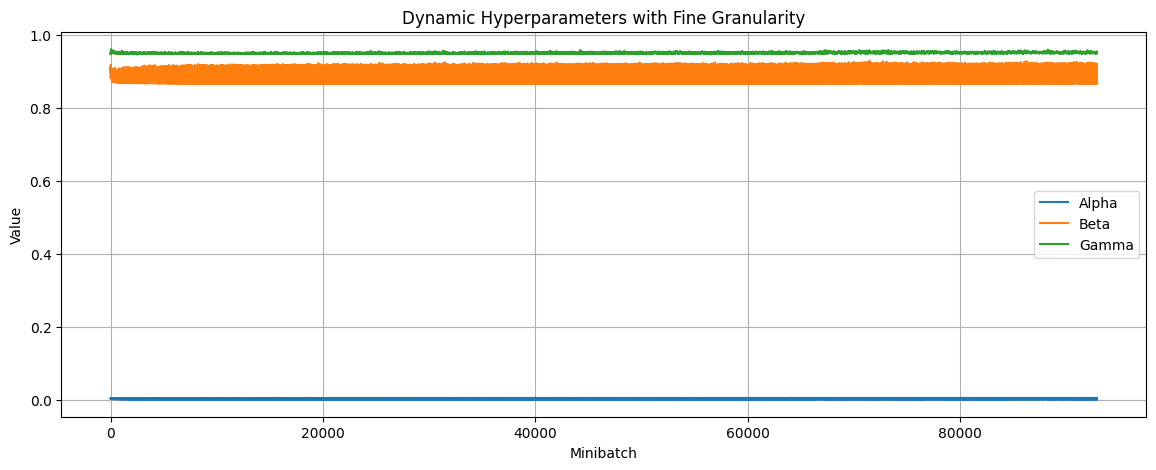

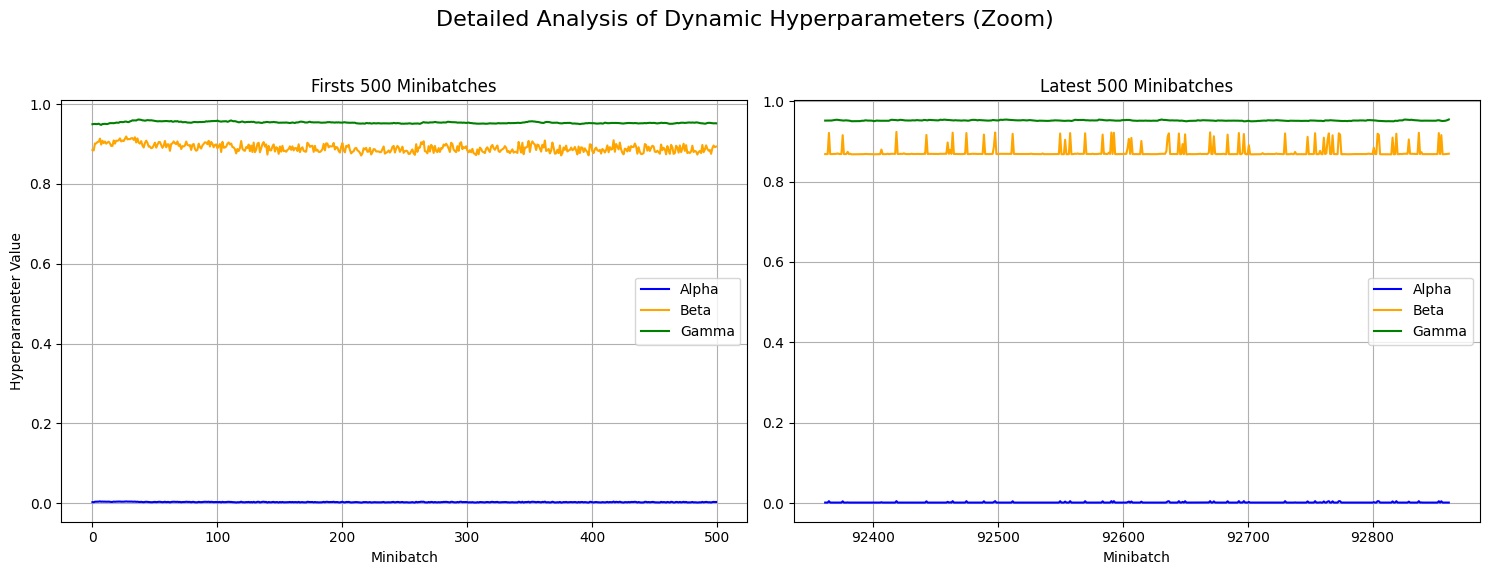


--- Generating Loss vs. Average Alpha Graph by Epoch ---


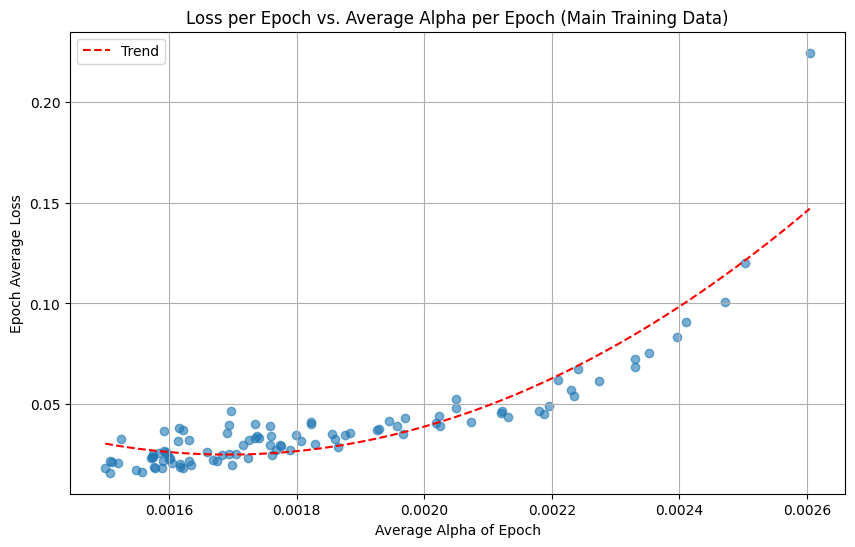


--- Generating Robbins-Monro Ratio Graph ---


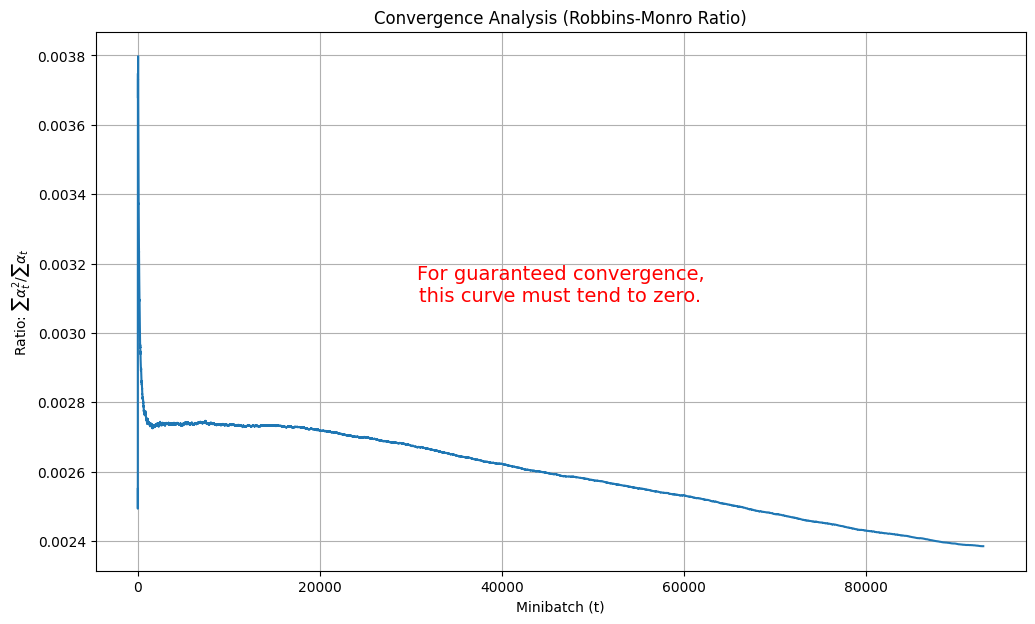


--- Generating Loss vs. Learning Rate (alpha) Graph by Minibatch ---


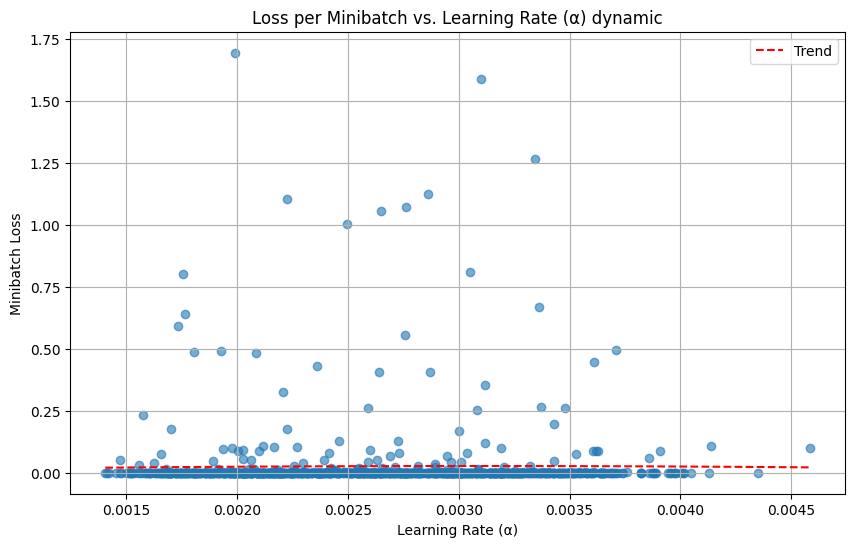


--- Generating Gradient Norm Graph by Minibatch ---


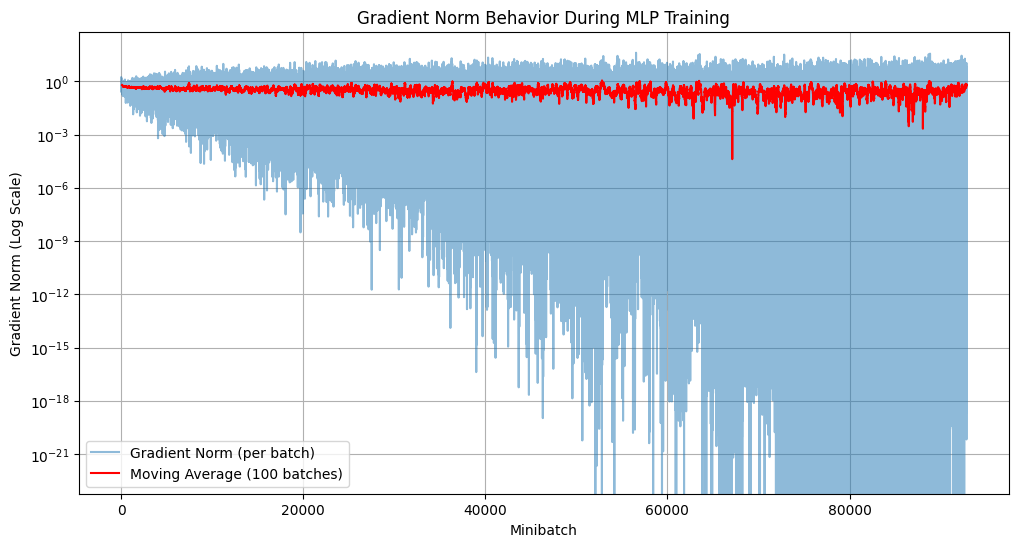

In [4]:

###############################################################################################################################################
######### VISUALIZATION OF THE SOFTSIGN FUNCTION USED TO SMOOTH THE LEARNING RATE ALPHA AS A FUNCTION OF THE VARIATION OF THE GRADIENT#########
###############################################################################################################################################

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def softsign(x):
    return x / (1 + np.abs(x))

def soft_root_sign(x):
    return x / np.sqrt(1 + x**2)

def param_softsign(x, a=1, s=1):
    return a * x / (np.abs(x)**s + 1)

x = np.linspace(-10, 10, 500)

plt.figure(figsize=(12, 8))

# Main Functions
plt.plot(x, sigmoid(x), label='Sigmoid', linewidth=2)
plt.plot(x, tanh(x), label='Tanh', linewidth=2)
plt.plot(x, softsign(x), label='Softsign', linewidth=2)
plt.plot(x, soft_root_sign(x), label='Soft-Root-Sign', linewidth=2)

# Parametric softsigns
for (a, s) in [(1, 0.5), (1, 1), (1, 2), (2, 1), (5, 1)]:
    plt.plot(x, param_softsign(x, a, s), '--', label=f'Param Softsign a={a}, s={s}')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axhline(1, color='gray', linewidth=0.5, linestyle='--')
plt.axhline(-1, color='gray', linewidth=0.5, linestyle='--')
plt.grid(True)
plt.legend()
plt.title('Comparison of activation functions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

# Visualizing the Effect of Flattening Factor T

z = np.linspace(-20, 20, 400)
original_softsign = z / (1 + np.abs(z))
generalized_softsign_T5 = z / (5 + np.abs(z))
generalized_softsign_T10 = z / (10 + np.abs(z))

plt.figure(figsize=(10, 6))
plt.plot(z, original_softsign, label='Original Softsign (T=1)')
plt.plot(z, generalized_softsign_T5, label='Generalized Softsign (T=5)', linewidth=2)
plt.plot(z, generalized_softsign_T10, label='Generalized Softsign (T=10)', linewidth=2, linestyle='--')
plt.title('Exploring the Possibilities of the Softsign Function')
plt.xlabel('Input z')
plt.ylabel('Output')
plt.grid(True)
plt.legend()
plt.show()


#######################################################################################################
#######################################################################################################


"""
Implementation of
Adam with Hierarchical and Dynamic Hyperparameters (Adam-HD)
and trajectory limit constraints (Clipping).
"""

# 1. IMPORTATION OF LIBRARIES AND AUXILIARY FUNCTIONS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from collections import deque

# Libraries for MLP and MNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Reproducibility
torch.manual_seed(0)

#######################################################################################################
#######################################################################################################

K_AGRESSIVIDADE_GLOBAL = 10.0
# efines the Flattening Factor T that will be used in both implementations
FLATTENING_FACTOR_T_GLOBAL = 10.0
NUMERO_DE_PASSOS = 100 ######## NUMBER OF EPOCHS ########

#######################################################################################################
#######################################################################################################

# Define the 2D loss function we want to minimize.
def loss(phi0, phi1):
    height = np.exp(-0.5 * (phi1 * phi1) * 4.0)
    height = height * np.exp(-0.5 * (phi0 - 0.7) * (phi0 - 0.7) / 4.0)
    return 1.0 - height

# Calculate the gradient of the loss function numerically.
def get_loss_gradient(phi0, phi1):
    delta_phi = 0.00001
    gradient = np.zeros((2, 1))
    gradient[0] = (loss(phi0 + delta_phi / 2.0, phi1) - loss(phi0 - delta_phi / 2.0, phi1)) / delta_phi
    gradient[1] = (loss(phi0, phi1 + delta_phi / 2.0) - loss(phi0, phi1 - delta_phi / 2.0)) / delta_phi
    return gradient[:, 0]

# Calculates the loss landscape for a fixed area.
def get_loss_function_for_plot(phi0_range=(-1.0, 1.0), phi1_range=(-1.0, 1.0)):
    phi0_values = np.arange(phi0_range[0], phi0_range[1], 0.01)
    phi1_values = np.arange(phi1_range[0], phi1_range[1], 0.01)

    phi0mesh, phi1mesh = np.meshgrid(phi0_values, phi1_values)
    loss_function = np.zeros((phi1_values.size, phi0_values.size))

    for idphi1, phi1 in enumerate(phi1_values):
        for idphi0, phi0 in enumerate(phi0_values):
            loss_function[idphi1, idphi0] = loss(phi0, phi1)

    return loss_function, phi0mesh, phi1mesh

# Code for colormap
my_colormap_vals_hex = (
    '2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09',
    '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f',
    '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814',
    '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18',
    '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d',
    '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821',
    '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26',
    '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a',
    '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f',
    '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134',
    '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a',
    '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f',
    '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545',
    '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b',
    'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451',
    'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57',
    'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d',
    'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64',
    'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b',
    'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72',
    'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a',
    'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81',
    'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589',
    'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91',
    'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a',
    'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3',
    'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac',
    'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6',
    'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf',
    'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca',
    'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5',
    'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0'
)
my_colormap_vals_dec = np.array([int(element, base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec / (256 * 256))
g = np.floor((my_colormap_vals_dec - r * 256 * 256) / 256)
b = np.floor(my_colormap_vals_dec - r * 256 * 256 - g * 256)
my_colormap_vals = np.vstack((r, g, b)).transpose() / 255.0
my_colormap = ListedColormap(my_colormap_vals)

def draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, opt_path):
    fig = plt.figure()
    ax = plt.axes()
    fig.set_size_inches(7, 7)
    ax.contourf(phi0mesh, phi1mesh, loss_function, 256, cmap=my_colormap)
    ax.contour(phi0mesh, phi1mesh, loss_function, 20, colors=['#80808080'])
    ax.plot(opt_path[0, :], opt_path[1, :], '-', color='#a0d9d3ff')
    ax.plot(opt_path[0, :], opt_path[1, :], '.', color='#a0d9d3ff', markersize=10)
    ax.set_xlabel(r"$\phi_0$")
    ax.set_ylabel(r"$\phi_1$")
    plt.show()

# --- 3. IMPLEMENTATION OF THE NEW ALGORITHM: ADAM-HD (Hierarchical and Dynamic) ---
# <<<< CHANGE 1: Added flattening_factor_T to the function >>>>
def adam_hierarquico_dinamico(start_posn, n_steps,
                               # Limits for hyperparameters
                               alpha_range=(0.01, 0.2), # (min, max)
                               beta_range=(0.85, 0.99), # (min, max)
                               gamma_range=(0.99, 0.999), # (min, max)
                               # Control parameters for signals
                               k_agressividade=K_AGRESSIVIDADE_GLOBAL, # Sensitivity to the gradient norm
                               flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL, # Flattening factor
                               smoothing_direcao=0.9, #Smoothing for cosine
                               epsilon=1e-8):

    # --- Inicializtions ---
    grad_path = np.zeros((2, n_steps + 1))
    grad_path[:, 0] = start_posn[:, 0]
    m = np.zeros_like(grad_path[:, 0])
    v = np.zeros_like(grad_path[:, 0])
    grad_anterior = np.zeros_like(grad_path[:,0])
    cosseno_suavizado = 0.0

    # Viewing histories
    alpha_hist, beta_hist, gamma_hist = [], [], []
    z_hist, softsign_hist, factor_agressividade_hist = [], [], [] # New histories

    for c_step in range(n_steps):
        pos_atual = grad_path[:, c_step]
        grad_atual = get_loss_gradient(pos_atual[0], pos_atual[1])

        # --- CALCULATION OF CONTROL SIGNALS ---
        grad_norm = np.linalg.norm(grad_atual)
        z = k_agressividade * (grad_norm - 0.5)

        # <<<< CHANGE 2: Use of Generalized Softsign >>>>
        softsign_val = z / (flattening_factor_T + np.abs(z))

        factor_agressividade = 0.5 * (softsign_val + 1)

        # Stores the new values for plotting
        z_hist.append(z)
        softsign_hist.append(softsign_val)
        factor_agressividade_hist.append(factor_agressividade)

        if np.linalg.norm(grad_anterior) > 0 and grad_norm > 0:
            cosseno_atual = np.dot(grad_atual, grad_anterior) / (grad_norm * np.linalg.norm(grad_anterior))
        else:
            cosseno_atual = 0.0
        cosseno_suavizado = smoothing_direcao * cosseno_suavizado + (1 - smoothing_direcao) * cosseno_atual
        factor_direcao = (cosseno_suavizado + 1) / 2.0

        alpha_min, alpha_max = alpha_range
        alpha_dyn = alpha_min + (alpha_max - alpha_min) * factor_agressividade

        beta_min, beta_max = beta_range
        beta_alvo = beta_min + (beta_max - beta_min) * factor_direcao
        beta_dyn = factor_agressividade * beta_alvo + (1 - factor_agressividade) * beta_min

        gamma_min, gamma_max = gamma_range
        gamma_dyn = gamma_min + (gamma_max - gamma_min) * factor_direcao

        alpha_hist.append(alpha_dyn); beta_hist.append(beta_dyn); gamma_hist.append(gamma_dyn)

        m = beta_dyn * m + (1 - beta_dyn) * grad_atual
        v = gamma_dyn * v + (1 - gamma_dyn) * np.square(grad_atual)

        m_tilde = m / (1 - np.power(beta_dyn, c_step + 1))
        v_tilde = v / (1 - np.power(gamma_dyn, c_step + 1))

        grad_path[:, c_step + 1] = pos_atual - alpha_dyn * m_tilde / (np.sqrt(v_tilde) + epsilon)

        grad_anterior = grad_atual

    # --- VIEWING RESULTS ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.plot(alpha_hist); plt.title('Dynamic Alpha'); plt.grid(True); plt.xlabel('Epoch')
    plt.subplot(1, 3, 2); plt.plot(beta_hist); plt.title('Dynamic Beta'); plt.grid(True); plt.xlabel('Epoch')
    plt.subplot(1, 3, 3); plt.plot(gamma_hist); plt.title('Dynamic Gamma'); plt.grid(True); plt.xlabel('Epoch')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.plot(z_hist); plt.title('z (Softsign entry)'); plt.grid(True); plt.xlabel('Epoch')
    plt.subplot(1, 3, 2); plt.plot(softsign_hist); plt.title('softsign_val'); plt.grid(True); plt.xlabel('Epoch')
    plt.subplot(1, 3, 3); plt.plot(factor_agressividade_hist); plt.title('aggressiveness_factor'); plt.grid(True); plt.xlabel('Epoch')
    plt.tight_layout(); plt.show()

    return grad_path

# --- 4. EXECUTION OF THE NEW ALGORITHM ---
print("\nRunning the Adam Algorithm with Hierarchical and Dynamic Hyperparameters (Adam-HD)...")

loss_function, phi0mesh, phi1mesh = get_loss_function_for_plot(phi0_range=(-1.2, 1.2), phi1_range=(-1.2, 1.2))
start_posn = np.zeros((2, 1)); start_posn[0, 0] = -0.7; start_posn[1, 0] = -0.9
numero_de_passos = NUMERO_DE_PASSOS ############################# NUMBER OF EPOCHS DEFINED ABOVE AT THE BEGINNING OF THE CODE ###################################
grad_path_hd = adam_hierarquico_dinamico(start_posn, n_steps=numero_de_passos)

print("\nPlotting the trajectory in the fixed loss landscape:")
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path_hd)

# --- NEW SECTION START: DEEP MLP WITH MNIST ---

class MLPDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# <<<< CHANGE 3: Added flattening_factor_T to the class >>>>
class AdamHDOptimizer(torch.optim.Optimizer):
    def __init__(self, params, alpha_range=(0.0001, 0.005), beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 k_agressividade=K_AGRESSIVIDADE_GLOBAL,
                 flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL, # New hyperparameter
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):

        defaults = dict(alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
                        k_agressividade=k_agressividade, flattening_factor_T=flattening_factor_T,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon,
                        beta_norm=beta_norm)
        super().__init__(params, defaults)
        self.alpha_hist = []
        self.beta_hist = []
        self.gamma_hist = []
        self.grad_norm_hist = []

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            k = group['k_agressividade']
            T = group['flattening_factor_T']
            smoothing = group['smoothing_direcao']
            eps = group['epsilon']
            beta_norm = group['beta_norm']

            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                grad = p.grad.data

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)

                state['step'] += 1
                m, v = state['m'], state['v']
                grad_prev, cos_smooth = state['grad_prev'], state['cos_smooth']
                grad_norm = grad.norm()

                avg_grad_norm = state['avg_grad_norm']
                if avg_grad_norm == 0:
                    avg_grad_norm = grad_norm.clone()
                else:
                    avg_grad_norm = beta_norm * avg_grad_norm + (1 - beta_norm) * grad_norm
                state['avg_grad_norm'] = avg_grad_norm.clone()

                z = k * ( (grad_norm / (avg_grad_norm + eps)) - 1.0 )

                softsign = z / (T + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)

                if grad_prev.norm() > 0 and grad_norm > 0:
                    cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm())
                else:
                    cos_atual = torch.tensor(0.0, device=p.device)
                cos_smooth = smoothing * cos_smooth + (1 - smoothing) * cos_atual
                factor_direcao = (cos_smooth + 1) / 2.0

                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao

                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)

                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2

                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)

                state['grad_prev'] = grad.clone()
                state['cos_smooth'] = cos_smooth.clone()

                if id(p) == id(group['params'][0]):
                    self.alpha_hist.append(alpha.item())
                    self.beta_hist.append(beta.item())
                    self.gamma_hist.append(gamma.item())
                    self.grad_norm_hist.append(grad_norm.item())

# --- Training with Adam-HD ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=1000, shuffle=False)

model = MLPDeep().to(device)

# <<<< CHANGE 5: Instantiating the optimizer with the new parameters >>>>
# Tune K_AGRESSIVITY_GLOBAL and FLATTENING_FACTOR_T_GLOBAL at the top of the script
optimizer = AdamHDOptimizer(model.parameters(),
                            k_agressividade=K_AGRESSIVIDADE_GLOBAL,
                            flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL,
                            alpha_range=(0.0001, 0.005)) # Using a more conservative alpha range

criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []
weights_history = []

print("\nTraining Deep MLP with MNIST using Adam-HD...")
for epoch in range(1, numero_de_passos): ############################### NUMBER OF EPOCHS################################
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- Saves weights at the end of each epoch ---
    with torch.no_grad():
        epoch_weights = torch.cat([p.data.view(-1) for p in model.parameters()])
        weights_history.append(epoch_weights.cpu().numpy())
    # ---------------------------------------------

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)

print(f"\nFinal Accuracy with Adam-HD: {test_accuracies[-1]:.2f}%")

# --- PERFORMANCE GRAPHICS ---
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_accuracies, marker='s', color='orange')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(optimizer.alpha_hist, label='Alpha')
plt.plot(optimizer.beta_hist, label='Beta')
plt.plot(optimizer.gamma_hist, label='Gamma')
plt.title('Dynamic Hyperparameters (batch-level)')
plt.xlabel('Minibatch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SEPARATE GRAPH WITH MORE GRANULARITY ---
if optimizer.alpha_hist: # Check if the list is not empty
    plt.figure(figsize=(14, 5))
    plt.plot(optimizer.alpha_hist, label='Alpha', linewidth=1.5)
    plt.plot(optimizer.beta_hist, label='Beta', linewidth=1.5)
    plt.plot(optimizer.gamma_hist, label='Gamma', linewidth=1.5)
    plt.title('Dynamic Hyperparameters with Fine Granularity')
    plt.xlabel('Minibatch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Defines the number of start and end points to display
zoom_points = 500

if len(optimizer.alpha_hist) > zoom_points * 2:
    plt.figure(figsize=(15, 6))
    plt.suptitle('Detailed Analysis of Dynamic Hyperparameters (Zoom)', fontsize=16)

    # --- Subplot 1: Zoom in on the START of the training ---
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(optimizer.alpha_hist[:zoom_points], label='Alpha', color='blue')
    ax1.plot(optimizer.beta_hist[:zoom_points], label='Beta', color='orange')
    ax1.plot(optimizer.gamma_hist[:zoom_points], label='Gamma', color='green')
    ax1.set_title(f'Firsts {zoom_points} Minibatches')
    ax1.set_xlabel('Minibatch')
    ax1.set_ylabel('Hyperparameter Value')
    ax1.legend()
    ax1.grid(True)

    # ---Subplot 2: Zoom in on the END of training ---
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(range(len(optimizer.alpha_hist) - zoom_points, len(optimizer.alpha_hist)),
             optimizer.alpha_hist[-zoom_points:], label='Alpha', color='blue')
    ax2.plot(range(len(optimizer.beta_hist) - zoom_points, len(optimizer.beta_hist)),
             optimizer.beta_hist[-zoom_points:], label='Beta', color='orange')
    ax2.plot(range(len(optimizer.gamma_hist) - zoom_points, len(optimizer.gamma_hist)),
             optimizer.gamma_hist[-zoom_points:], label='Gamma', color='green')
    ax2.set_title(f'Latest {zoom_points} Minibatches')
    ax2.set_xlabel('Minibatch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("\nUnable to generate zoomed graph: number of minibatches is less than required for zooming.")

# --- END OF MLP SECTION ---
#######################################################################################################################
#######################################################################################################################
# --- NEW GRAPH: Loss vs. Learning Rate of Core Training ---

# Check if the training was performed
if train_losses and optimizer.alpha_hist:
    print("\n--- Generating Loss vs. Average Alpha Graph by Epoch ---")

    # Calculates the number of batches per epoch
    num_batches_per_epoch = len(train_loader)

    # Calculates the average alpha for each epoch
    avg_alpha_per_epoch = []
    for i in range(len(train_losses)):
        start_index = i * num_batches_per_epoch
        end_index = start_index + num_batches_per_epoch
        epoch_alphas = optimizer.alpha_hist[start_index:end_index]
        if epoch_alphas:
            avg_alpha_per_epoch.append(np.mean(epoch_alphas))
        else:
            # If training is interrupted, avoid errors
            break

    # Ensures the same number of points for loss and alpha
    num_epochs_to_plot = len(avg_alpha_per_epoch)

    # Creates the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_alpha_per_epoch, train_losses[:num_epochs_to_plot], alpha=0.6)

    # Adds a trendline (simple polynomial regression) to aid visualization
    if num_epochs_to_plot > 2:
        try:
            z = np.polyfit(avg_alpha_per_epoch, train_losses[:num_epochs_to_plot], 2)
            p = np.poly1d(z)
            xp = np.linspace(min(avg_alpha_per_epoch), max(avg_alpha_per_epoch), 100)
            plt.plot(xp, p(xp), "r--", label="Trend")
        except:
             print("Unable to generate trend line.")

    plt.title('Loss per Epoch vs. Average Alpha per Epoch (Main Training Data)')
    plt.xlabel('Average Alpha of Epoch')
    plt.ylabel('Epoch Average Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- NEW GRAPH: Robbins-Monro Ratio Analysis ---

print("\n--- Generating Robbins-Monro Ratio Graph ---")

# Check if the training was performed
if optimizer.alpha_hist:
    # Calculates cumulative sums
    sum_alpha = np.cumsum(optimizer.alpha_hist)
    sum_alpha_sq = np.cumsum(np.array(optimizer.alpha_hist)**2)

    # Calcula a razão, evitando divisão por zero no início
    ratio = sum_alpha_sq / (sum_alpha + 1e-9)

    plt.figure(figsize=(12, 7))
    plt.plot(ratio)
    plt.title(r'Convergence Analysis (Robbins-Monro Ratio)')
    plt.xlabel('Minibatch (t)')
    plt.ylabel(r'Ratio: $\sum \alpha_t^2 / \sum \alpha_t$')
    plt.grid(True)
    plt.text(0.5, 0.5, 'For guaranteed convergence,\nthis curve must tend to zero.',
             transform=plt.gca().transAxes, ha='center', fontsize=14, color='red')
    plt.show()

# --- NEW GRAPH: Loss vs. Learning Rate per Minibatch ---

# Check if there are enough histories
if len(optimizer.alpha_hist) > 0 and len(train_losses) > 0:
    print("\n--- Generating Loss vs. Learning Rate (alpha) Graph by Minibatch ---")

    # Concatenates all losses per minibatch (flatten)
    all_minibatch_losses = []

    model.eval()  # Make sure there is no dropout/batchnorm affecting
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            all_minibatch_losses.append(loss.item())

    # Ensures sizes match
    min_len = min(len(all_minibatch_losses), len(optimizer.alpha_hist))
    x = optimizer.alpha_hist[:min_len]
    y = all_minibatch_losses[:min_len]

    # Creates the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.6)

    # Add trendline if there are enough points
    if len(x) > 2:
        try:
            z = np.polyfit(x, y, 2)  # Second-order polynomial regression
            p = np.poly1d(z)
            xp = np.linspace(min(x), max(x), 100)
            plt.plot(xp, p(xp), "r--", label="Trend")
        except:
            print("Unable to fit trendline.")

    plt.title('Loss per Minibatch vs. Learning Rate (α) dynamic')
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Minibatch Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

####################################################################
# --- NEW GRAPH: GRADIENT STANDARD BY MINIBATCH ---
####################################################################

if hasattr(optimizer, 'grad_norm_hist') and optimizer.grad_norm_hist:
    print("\n--- Generating Gradient Norm Graph by Minibatch ---")

    plt.figure(figsize=(12, 6))

    # Plot the norm of the original gradient (batch by batch), which is quite noisy
    plt.plot(optimizer.grad_norm_hist, label='Gradient Norm (per batch)', alpha=0.5)

    # Add a moving average to smooth the curve and see the trend
    window_size = 100 # Moving average window size
    if len(optimizer.grad_norm_hist) > window_size:
        # Use np.convolve to calculate the moving average efficiently
        moving_avg = np.convolve(optimizer.grad_norm_hist, np.ones(window_size)/window_size, mode='valid')
        # Adjust the x-axis to the moving average
        plt.plot(np.arange(window_size - 1, len(optimizer.grad_norm_hist)), moving_avg, color='red', label=f'Moving Average ({window_size} batches)')

    plt.title('Gradient Norm Behavior During MLP Training')
    plt.xlabel('Minibatch')
    plt.ylabel('Gradient Norm (Log Scale)')
    plt.yscale('log') # Logarithmic scale is better for visualizing orders of magnitude drop
    plt.legend()
    plt.grid(True)
    plt.show()



Treinando com Adam...
Epoch 1: Loss = 0.2260 | Accuracy = 96.55%
Epoch 2: Loss = 0.0963 | Accuracy = 97.32%
Epoch 3: Loss = 0.0691 | Accuracy = 96.86%
Epoch 4: Loss = 0.0509 | Accuracy = 97.53%
Epoch 5: Loss = 0.0432 | Accuracy = 98.02%
Epoch 6: Loss = 0.0364 | Accuracy = 97.69%
Epoch 7: Loss = 0.0309 | Accuracy = 98.09%
Epoch 8: Loss = 0.0285 | Accuracy = 98.11%
Epoch 9: Loss = 0.0243 | Accuracy = 97.96%
Epoch 10: Loss = 0.0227 | Accuracy = 97.99%
Epoch 11: Loss = 0.0224 | Accuracy = 97.84%
Epoch 12: Loss = 0.0181 | Accuracy = 98.06%
Epoch 13: Loss = 0.0190 | Accuracy = 98.23%
Epoch 14: Loss = 0.0156 | Accuracy = 98.17%
Epoch 15: Loss = 0.0137 | Accuracy = 98.19%
Epoch 16: Loss = 0.0155 | Accuracy = 98.25%
Epoch 17: Loss = 0.0124 | Accuracy = 98.10%
Epoch 18: Loss = 0.0154 | Accuracy = 97.73%
Epoch 19: Loss = 0.0137 | Accuracy = 98.30%
Epoch 20: Loss = 0.0109 | Accuracy = 98.18%
Epoch 21: Loss = 0.0129 | Accuracy = 98.30%
Epoch 22: Loss = 0.0138 | Accuracy = 98.11%
Epoch 23: Loss = 0

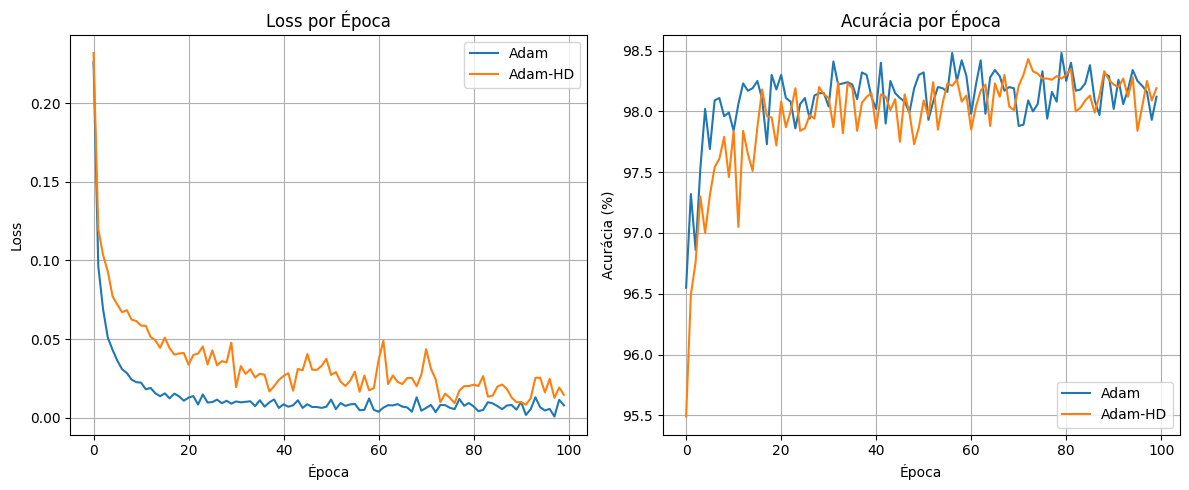

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Reprodutibilidade
torch.manual_seed(0)

# Hiperparâmetros Globais
K_AGRESSIVIDADE_GLOBAL = 10.0
FLATTENING_FACTOR_T_GLOBAL = 10.0
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Dataset e DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=1000, shuffle=False)

# Modelo MLP
class MLPDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.model(x)

# Otimizador Adam-HD
class AdamHDOptimizer(torch.optim.Optimizer):
    def __init__(self, params, alpha_range=(0.0001, 0.005), beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 k_agressividade=K_AGRESSIVIDADE_GLOBAL, flattening_factor_T=FLATTENING_FACTOR_T_GLOBAL,
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):
        defaults = dict(alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
                        k_agressividade=k_agressividade, flattening_factor_T=flattening_factor_T,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon, beta_norm=beta_norm)
        super().__init__(params, defaults)
        self.alpha_hist, self.beta_hist, self.gamma_hist, self.grad_norm_hist = [], [], [], []

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            k, T = group['k_agressividade'], group['flattening_factor_T']
            smoothing, eps, beta_norm = group['smoothing_direcao'], group['epsilon'], group['beta_norm']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                grad = p.grad.data
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)
                state['step'] += 1
                m, v = state['m'], state['v']
                grad_prev, cos_smooth = state['grad_prev'], state['cos_smooth']
                grad_norm = grad.norm()
                avg_grad_norm = state['avg_grad_norm']
                avg_grad_norm = grad_norm if avg_grad_norm == 0 else beta_norm * avg_grad_norm + (1 - beta_norm) * grad_norm
                state['avg_grad_norm'] = avg_grad_norm
                z = k * ((grad_norm / (avg_grad_norm + eps)) - 1.0)
                softsign = z / (T + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)
                cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm()) if grad_prev.norm() > 0 and grad_norm > 0 else torch.tensor(0.0, device=p.device)
                cos_smooth = smoothing * cos_smooth + (1 - smoothing) * cos_atual
                factor_direcao = (cos_smooth + 1) / 2.0
                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao
                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)
                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2
                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)
                state['grad_prev'] = grad.clone()
                state['cos_smooth'] = cos_smooth.clone()
                if id(p) == id(group['params'][0]):
                    self.alpha_hist.append(alpha.item())
                    self.beta_hist.append(beta.item())
                    self.gamma_hist.append(gamma.item())
                    self.grad_norm_hist.append(grad_norm.item())

# Função de treino/avaliação
def train_and_eval(model, optimizer, num_epochs=NUM_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_losses, test_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        # Avaliação
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        acc = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(acc)
        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f} | Accuracy = {acc:.2f}%")
    return train_losses, test_accuracies

# Execução Adam
print("\nTreinando com Adam...")
model_adam = MLPDeep()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
adam_loss, adam_acc = train_and_eval(model_adam, optimizer_adam, num_epochs=NUM_EPOCHS)

# Execução Adam-HD
print("\nTreinando com Adam-HD...")
model_adamhd = MLPDeep()
optimizer_adamhd = AdamHDOptimizer(model_adamhd.parameters())
adam_hd_loss, adam_hd_acc = train_and_eval(model_adamhd, optimizer_adamhd, num_epochs=NUM_EPOCHS)

# Gráficos Comparativos
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(adam_loss, label='Adam')
plt.plot(adam_hd_loss, label='Adam-HD')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(adam_acc, label='Adam')
plt.plot(adam_hd_acc, label='Adam-HD')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
